# Task 3: Diverse Explanations

## Imports and Data

In [42]:
import os
import pandas as pd
import textstat
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import entropy
import numpy as np
from sentence_transformers import SentenceTransformer, util
from itertools import combinations

In [43]:
data = pd.read_csv("data/answerList_data.csv")

# Filter to include only rows where TP == 1 or TN == 1
filtered_data = data[(data["TP"] == 1)] #| (data["TN"] == 1)]
print("Filtered data shape:", filtered_data.shape)

Filtered data shape: (228, 25)


In [44]:
# remove unneeded columns
filtered_data = filtered_data.drop(columns=["TP", "TN", "FP", "FN", "GroundTruth"])

In [45]:
filtered_data.columns

Index(['Answer.ID', 'FailingMethod', 'Question.ID', 'Answer.duration',
       'Answer.confidence', 'Answer.difficulty', 'Answer.option',
       'Answer.order', 'Answer.explanation', 'Code.LOC', 'Code.complexity',
       'Worker.ID', 'Worker.score', 'Worker.profession',
       'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender',
       'Worker.whereLearnedToCode', 'Worker.country',
       'Worker.programmingLanguage'],
      dtype='object')

In [46]:
df_golden = pd.read_csv("intermediate/task_02_golden_explanations.csv")
print("Golden explanations shape:", df_golden.shape)

Golden explanations shape: (8, 2)


In [47]:
failing_methods = ['HIT01_8', 'HIT02_24', 'HIT03_6', 'HIT04_7', 'HIT05_35', 'HIT06_51', 'HIT07_33', 'HIT08_54']
df_golden["FailingMethod"] = failing_methods * (len(df_golden) // len(failing_methods)) + failing_methods[:len(df_golden) % len(failing_methods)]
print("Merged shape (answers + gold):", df_golden.shape)

Merged shape (answers + gold): (8, 3)


In [48]:
merged_df = filtered_data.merge(df_golden[['FailingMethod', 'golden_explanation']], on="FailingMethod", how="inner")
print("Merged shape (answers + gold):", merged_df.shape)

Merged shape (answers + gold): (228, 21)


In [49]:
merged_df.head(3)

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,Answer.option,Answer.order,Answer.explanation,Code.LOC,...,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,golden_explanation
0,441,HIT01_8,1,140.407,4,3,YES,3,Minutes are set to -15; which is less then 0 a...,1,...,35Eg-6i-8G-2-6-8,3,Undergraduate_Student,3.0,49,Female,University,US,php,"The issue is `minutesOffset` variable, not the..."
1,443,HIT01_8,1,112.409,5,2,YES,3,In the code there is a check that 0 <= minutes...,1,...,286Ig-9C0E170,5,Undergraduate_Student,5.0,20,Male,University;Web,USA,c#,"The issue is `minutesOffset` variable, not the..."
2,444,HIT01_8,1,76.418,5,1,YES,3,There is a logical check for if minuteOffset i...,1,...,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,"The issue is `minutesOffset` variable, not the..."


## Metrics

In [50]:
def get_reading_ease_score(text):
    """
    Compute Flesch Reading Ease score via textstat.
    Higher = easier to read. Our threshold is >= 60.
    """
    return textstat.flesch_reading_ease(text)

def get_cosine_similarity(text_a, text_b):
    """
    Encode the two texts using a sentence-transformers model
    and return the cosine similarity (0 to 1).
    """
    # We use the default sentence transformer model for this task
    st_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = st_model.encode([text_a, text_b], convert_to_tensor=True)
    sim = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return float(sim.item())  

In [51]:
merged_df["ReadingEaseScore"] = merged_df["Answer.explanation"].apply(get_reading_ease_score)
merged_df["CosineSimilarity"] = merged_df.apply(lambda row: get_cosine_similarity(row["Answer.explanation"], row["golden_explanation"]), axis=1)

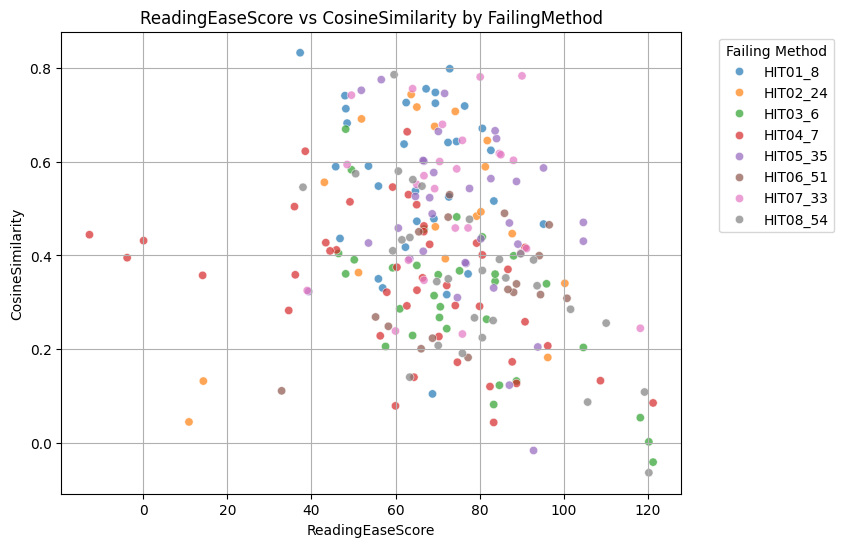

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'FailingMethod' is a categorical variable
merged_df["FailingMethod"] = merged_df["FailingMethod"].astype("category")

# Assign a unique color to each failing method
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_df, 
    x="ReadingEaseScore", 
    y="CosineSimilarity", 
    hue="FailingMethod", 
    palette="tab10", 
    alpha=0.7
)

plt.xlabel("ReadingEaseScore")
plt.ylabel("CosineSimilarity")
plt.title("ReadingEaseScore vs CosineSimilarity by FailingMethod")
plt.legend(title="Failing Method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


## 3.1. Entropy Measurement

In [53]:
"""
    The entropy of categorical variables is measured by computing the 
    probability distribution of unique values and applying the Shannon entropy formula. 
    For numerical variables, entropy is estimated by first binning the data into a histogram, 
    treating the bin frequencies as a probability distribution, and then computing the entropy 
    while adding a small constant (1e-9) to avoid logarithm errors.
"""

entropy_features = ['Answer.duration', 'Answer.explanation', 'Answer.order', 
                    'Answer.confidence', 'Answer.difficulty', 'Code.LOC', 
                    'Code.complexity', 'Worker.score', 'Worker.profession',
                    'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender',
                    'Worker.whereLearnedToCode', 'Worker.country',
                    'Worker.programmingLanguage'
                    ]

# Function to compute entropy of categorical variables
def categorical_entropy(series):
    value_counts = series.value_counts(normalize=True)  # Get probability distribution
    return entropy(value_counts, base=2)  # Compute entropy

# Function to compute entropy of numerical variables using binning
def numerical_entropy(series, bins=10):
    hist, bin_edges = np.histogram(series.dropna(), bins=bins, density=True)  # Histogram as probability distribution
    return entropy(hist + 1e-9, base=2)  # Compute entropy, avoiding log(0)

# Function to compute entropy for a subset
def subset_entropy(subset, max_entropies):
    entropy_score = 0
    max_entropy = 0  # To store the sum of max entropies for normalization

    for col in entropy_features:
        if col in subset.columns:  # Ensure the column exists in the subset
            if pd.api.types.is_numeric_dtype(subset[col]):
                col_entropy = numerical_entropy(subset[col])
            else:
                col_entropy = categorical_entropy(subset[col])

            max_col_entropy = max_entropies.get(col, 1)  # Get max entropy, default to 1 if missing
            entropy_score += col_entropy
            max_entropy += max_col_entropy  # Accumulate max entropy

    return entropy_score / max_entropy if max_entropy > 0 else 0


In [54]:
# Compute entropy for each column
column_entropies = {}
for col in merged_df.columns:
    if pd.api.types.is_numeric_dtype(merged_df[col]):
        column_entropies[col] = numerical_entropy(merged_df[col])
    else:
        column_entropies[col] = categorical_entropy(merged_df[col])

# Sort dicitonary by entropy
sorted_entropies = dict(sorted(column_entropies.items(), key=lambda x: x[1], reverse=True))
print(sorted_entropies)

{'Answer.explanation': np.float64(7.832890014164741), 'Worker.ID': np.float64(7.040313739964276), 'Worker.programmingLanguage': np.float64(5.538939927979547), 'Worker.whereLearnedToCode': np.float64(3.5225571984037276), 'Answer.ID': np.float64(3.1322922714691317), 'CosineSimilarity': np.float64(3.0845532287686863), 'Question.ID': np.float64(3.0718926569008373), 'FailingMethod': np.float64(2.9409446618264026), 'golden_explanation': np.float64(2.9409446618264026), 'Worker.country': np.float64(2.7182181711508586), 'Worker.age': np.float64(2.605936636098558), 'ReadingEaseScore': np.float64(2.6052232996703952), 'Worker.yearsOfExperience': np.float64(2.442513595798911), 'Answer.difficulty': np.float64(2.2590177599940318), 'Worker.profession': np.float64(2.0753195498536066), 'Answer.confidence': np.float64(2.0034425646624485), 'Code.LOC': np.float64(1.620811680933113), 'Answer.order': np.float64(1.464633203966641), 'Worker.score': np.float64(1.4602819878739632), 'Code.complexity': np.float64(

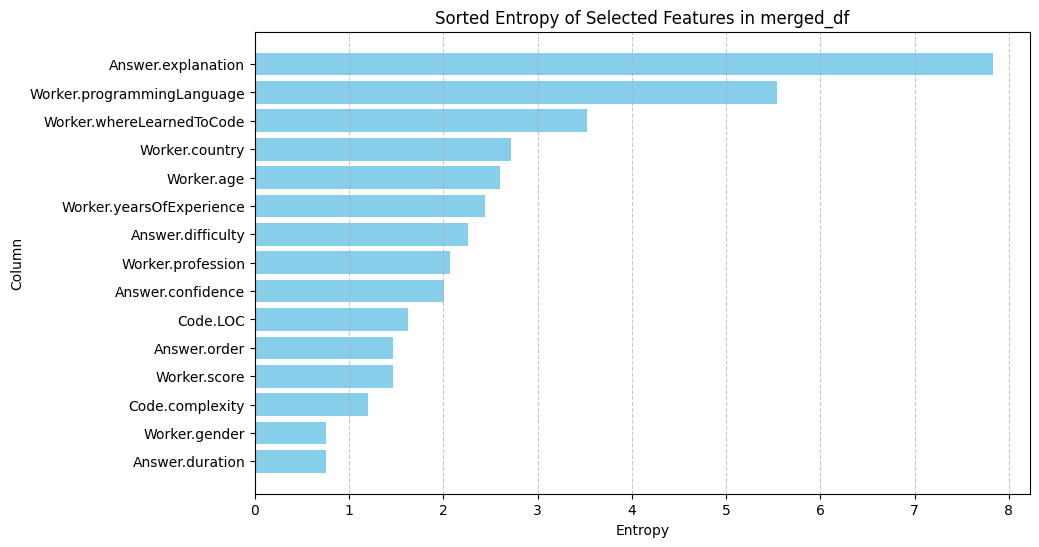

In [55]:
# Filter the sorted_entropies dictionary to include only the features in entropy_features
filtered_entropies = {col: sorted_entropies[col] for col in entropy_features if col in sorted_entropies}

# Sort the filtered entropies in descending order
sorted_filtered_entropies = dict(sorted(filtered_entropies.items(), key=lambda x: x[1], reverse=True))

# Extract column names and their corresponding entropy values
columns = list(sorted_filtered_entropies.keys())
entropies = list(sorted_filtered_entropies.values())

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(columns, entropies, color="skyblue")

# Invert the y-axis so the highest entropy appears at the top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel("Entropy")
plt.ylabel("Column")
plt.title("Sorted Entropy of Selected Features in merged_df")

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


In [56]:
max_entropies = {
    key: float(value) for key, value in filtered_entropies.items()
}
max_entropies

{'Answer.duration': 0.7558467399909603,
 'Answer.explanation': 7.832890014164741,
 'Answer.order': 1.464633203966641,
 'Answer.confidence': 2.0034425646624485,
 'Answer.difficulty': 2.2590177599940318,
 'Code.LOC': 1.620811680933113,
 'Code.complexity': 1.1999375166608093,
 'Worker.score': 1.4602819878739632,
 'Worker.profession': 2.0753195498536066,
 'Worker.yearsOfExperience': 2.442513595798911,
 'Worker.age': 2.605936636098558,
 'Worker.gender': 0.7588840483719566,
 'Worker.whereLearnedToCode': 3.5225571984037276,
 'Worker.country': 2.7182181711508586,
 'Worker.programmingLanguage': 5.538939927979547}

## 3.2. Max Readability & Max Similarity

In [57]:
max_reading_ease = merged_df["ReadingEaseScore"].max()
max_cosine_sim = merged_df["CosineSimilarity"].max()
print("Max reading ease score:", max_reading_ease)
print("Max cosine similarity:", max_cosine_sim)

Max reading ease score: 121.22
Max cosine similarity: 0.8326233625411987


In [58]:
# entry with max cosine similarity
max_cosine_sim_entry = merged_df[merged_df["CosineSimilarity"] == max_cosine_sim]
print("Max cosine similarity entry:")
print(max_cosine_sim_entry["Answer.explanation"].values[0])
print("Golden explanation:")
print(max_cosine_sim_entry["golden_explanation"].values[0])

# entry with max reading ease score
max_reading_ease_entry = merged_df[merged_df["ReadingEaseScore"] == max_reading_ease]
print("Max reading ease score entry:")
print(max_reading_ease_entry["Answer.explanation"].values[0])

Max cosine similarity entry:
The variable "minutesOffset" is checked incorrectly by the IF statement on line 279. Any negative value for "minutesOffset" will throw this exception; while the documentation states that "minutesOffset" can be negative in some cases.
Golden explanation:
The issue is `minutesOffset` variable, not the `hoursOffset`. The `hoursOffset` parameter is correctly handled, as it accepts integer values between -23 and 23, which is intended. If there were an issue with `hoursOffset`, an exception with the message "Hours out of range" would be thrown at lines 276-278. The failure shows "Minutes out of range," which corresponds to line 279 that checks `minutesOffset`. Therefore the logic of `minutesOffset` must be looked at.
Max reading ease score entry:
Yes


In [59]:
# Normalize scores
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

merged_df["ReadingEaseScore"] = normalize(merged_df["ReadingEaseScore"])
merged_df["CosineSimilarity"] = normalize(merged_df["CosineSimilarity"])


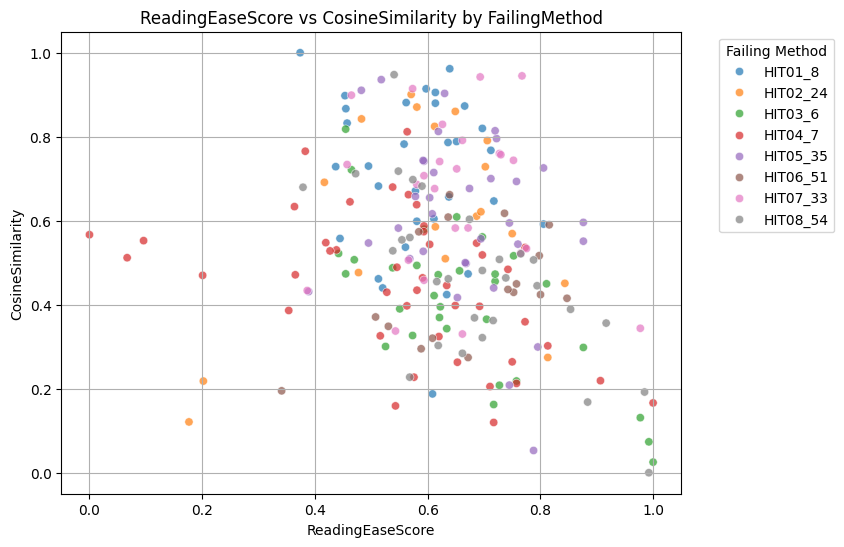

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'FailingMethod' is a categorical variable
merged_df["FailingMethod"] = merged_df["FailingMethod"].astype("category")

# Assign a unique color to each failing method
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_df, 
    x="ReadingEaseScore", 
    y="CosineSimilarity", 
    hue="FailingMethod", 
    palette="tab10", 
    alpha=0.7
)

plt.xlabel("ReadingEaseScore")
plt.ylabel("CosineSimilarity")
plt.title("ReadingEaseScore vs CosineSimilarity by FailingMethod")
plt.legend(title="Failing Method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


## 3.3. Maximum Diversity

In [66]:
# Weighted scoring function
def weighted_score(subset, alpha=0.3333, beta=0.3333, gamma=0.3333):
    entropy_score = subset_entropy(subset, max_entropies)
    readability_score = subset["ReadingEaseScore"].mean()
    similarity_score = subset["CosineSimilarity"].mean()
    return alpha * readability_score + beta * similarity_score + gamma * entropy_score


In [67]:
# Select a maximally diverse subset using exhaustive search

from itertools import combinations

def find_best_subsets(N, alpha, beta, gamma):
    best_subsets = {}
    subset_entropies = {}  # Dictionary to store entropy values

    for method, method_group in merged_df.groupby("FailingMethod"):
        print(f"Processing method {method}")
        best_subset = None
        max_score = -np.inf
        entropies = []  # List to store entropy values for this method

        for subset_indices in combinations(method_group.index, min(N, len(method_group))):
            subset = method_group.loc[list(subset_indices)]
            subset_score = weighted_score(subset, alpha, beta, gamma)
            subset_entropy_value = subset_entropy(subset, max_entropies)  # Compute entropy
            
            entropies.append((subset_indices, subset_entropy_value))  # Save entropy with subset indices

            if subset_score > max_score:
                max_score = subset_score
                best_subset = subset
        
        best_subsets[method] = best_subset
        subset_entropies[method] = entropies  # Store entropies for each method
    
    return best_subsets, subset_entropies


In [71]:
# Display selected explanations per failing method
def print_subsets(best_subsets):
    for method, subset in best_subsets.items():
        print(f"Failing Method: {method}")
        print("Entropy: ", subset_entropy(subset, max_entropies))
        print(subset[["Answer.ID", "ReadingEaseScore", "CosineSimilarity"]])
        print("---")

In [64]:
def plot_best_subsets(merged_df, best_subsets):
    plt.figure(figsize=(8, 6))

    # Use seaborn color palette
    palette = sns.color_palette("tab10", n_colors=len(best_subsets))

    # Plot all data points in light gray
    plt.scatter(merged_df["ReadingEaseScore"], merged_df["CosineSimilarity"], color="lightgray", alpha=0.5, label="All Data")

    # Plot each method's subset with a different color
    for i, (method, subset) in enumerate(best_subsets.items()):
        plt.scatter(subset["ReadingEaseScore"], subset["CosineSimilarity"], color=palette[i], alpha=0.8, label=method)

    # Labels and title
    plt.xlabel("ReadingEaseScore")
    plt.ylabel("CosineSimilarity")
    plt.title("ReadingEaseScore vs CosineSimilarity (All Methods)")
    plt.legend(title="Failing Method", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)


### NOT Diversity + Max Similarity (1/2) + Max Readability (1/2) (Follow-up Question 3.2.)

Failing Method: HIT01_8
Entropy:  0.45800215200353805
    Answer.ID  ReadingEaseScore  CosineSimilarity
7         450          0.665697          0.873117
13        243          0.639206          0.961856
19        252          0.613686          0.905406
---
Failing Method: HIT02_24
Entropy:  0.4099983411906188
    Answer.ID  ReadingEaseScore  CosineSimilarity
32         64          0.705843          0.790824
37         75          0.570778          0.900686
44         85          0.649056          0.860253
---
Failing Method: HIT03_6
Entropy:  0.49942977107414
    Answer.ID  ReadingEaseScore  CosineSimilarity
58        491          0.454593          0.818079
59        492          0.810910          0.449831
66        406          0.752556          0.516473
---
Failing Method: HIT04_7
Entropy:  0.4340005696026689
     Answer.ID  ReadingEaseScore  CosineSimilarity
82        1310          0.772778          0.536221
118        667          0.686889          0.546793
122        679         

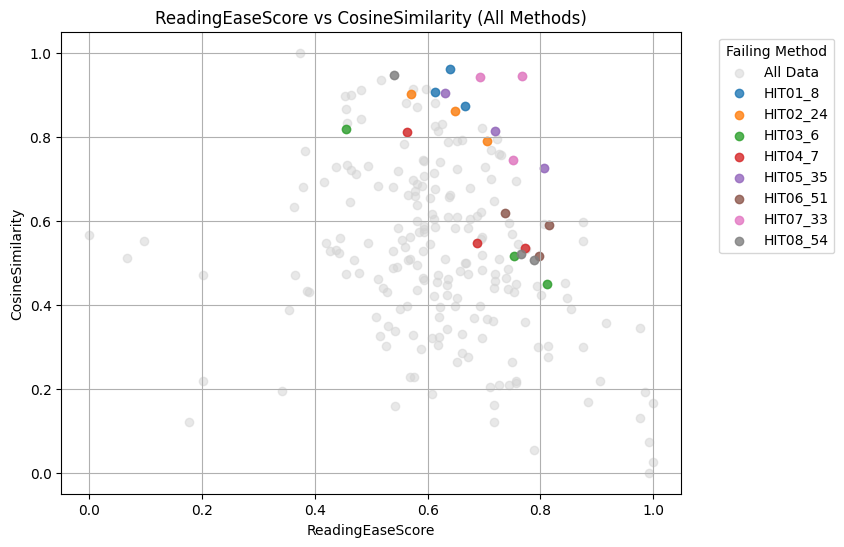

In [72]:
best_subsets_sim_read, subset_entropies_sim_read = find_best_subsets(3, 0.5, 0.5, 0.0)
print_subsets(best_subsets_sim_read)
plot_best_subsets(merged_df, best_subsets_sim_read)

### Max Diversity (1/3) + Max Similarity (1/3) + Max Readability (1/3)

/tmp/ipykernel_17203/431012939.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, method_group in merged_df.groupby("FailingMethod"):


Processing method HIT01_8
Processing method HIT02_24
Processing method HIT03_6
Processing method HIT04_7
Processing method HIT05_35
Processing method HIT06_51
Processing method HIT07_33
Processing method HIT08_54
Failing Method: HIT01_8
Entropy:  0.5517040902155512
    Answer.ID  ReadingEaseScore  CosineSimilarity
0         441          0.697038          0.819842
7         450          0.665697          0.873117
19        252          0.613686          0.905406
---
Failing Method: HIT02_24
Entropy:  0.4099983411906188
    Answer.ID  ReadingEaseScore  CosineSimilarity
32         64          0.705843          0.790824
37         75          0.570778          0.900686
44         85          0.649056          0.860253
---
Failing Method: HIT03_6
Entropy:  0.6039796038356268
    Answer.ID  ReadingEaseScore  CosineSimilarity
51        513          0.651593          0.609090
58        491          0.454593          0.818079
66        406          0.752556          0.516473
---
Failing Method:

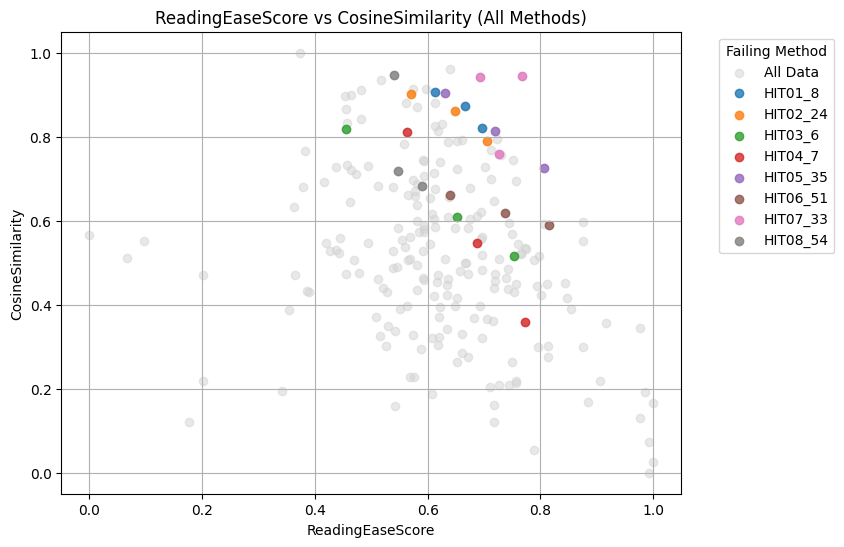

In [73]:
best_subsets_div_sim_read, subset_entropies_div_sim_read = find_best_subsets(3, 0.3333, 0.3333, 0.3333)
print_subsets(best_subsets_div_sim_read)
plot_best_subsets(merged_df, best_subsets_div_sim_read)

### Max Diversity (1/2) + Max Similarity (1/2) + NOT readability

Processing method HIT01_8


/tmp/ipykernel_17203/431012939.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, method_group in merged_df.groupby("FailingMethod"):


Processing method HIT02_24
Processing method HIT03_6
Processing method HIT04_7
Processing method HIT05_35
Processing method HIT06_51
Processing method HIT07_33
Processing method HIT08_54
Failing Method: HIT01_8
Entropy:  0.5168540595539206
    Answer.ID  ReadingEaseScore  CosineSimilarity
4         446          0.373778          1.000000
19        252          0.613686          0.905406
27        385          0.453324          0.897746
---
Failing Method: HIT02_24
Entropy:  0.4099983411906188
    Answer.ID  ReadingEaseScore  CosineSimilarity
32         64          0.705843          0.790824
37         75          0.570778          0.900686
44         85          0.649056          0.860253
---
Failing Method: HIT03_6
Entropy:  0.6039796038356268
    Answer.ID  ReadingEaseScore  CosineSimilarity
51        513          0.651593          0.609090
58        491          0.454593          0.818079
66        406          0.752556          0.516473
---
Failing Method: HIT04_7
Entropy:  0.53427

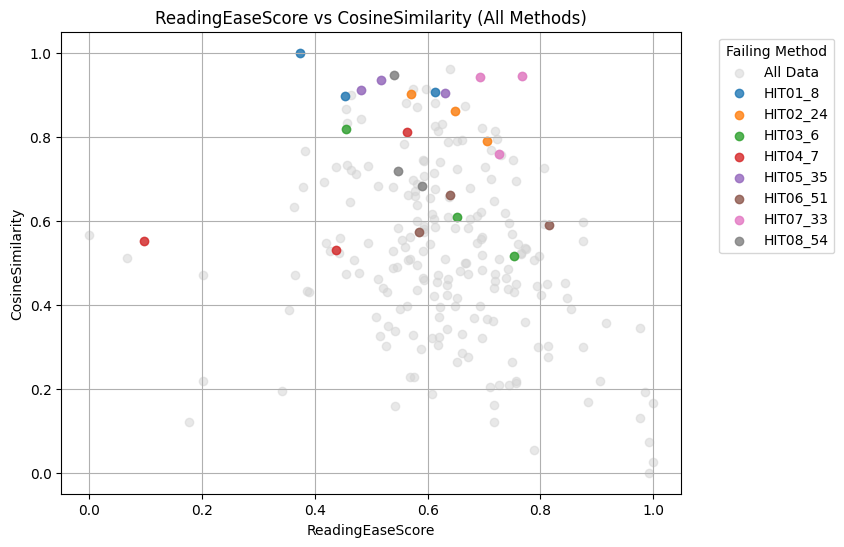

In [74]:
best_subsets_div_sim, subset_entropies_div_sim = find_best_subsets(3, 0.0, 0.5, 0.5)
print_subsets(best_subsets_div_sim)
plot_best_subsets(merged_df, best_subsets_div_sim)

### Max Diversity ONLY

Processing method HIT01_8


/tmp/ipykernel_17203/431012939.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, method_group in merged_df.groupby("FailingMethod"):


Processing method HIT02_24
Processing method HIT03_6
Processing method HIT04_7
Processing method HIT05_35
Processing method HIT06_51
Processing method HIT07_33
Processing method HIT08_54
Failing Method: HIT01_8
Entropy:  0.5691291238418227
    Answer.ID  ReadingEaseScore  CosineSimilarity
0         441          0.697038          0.819842
14        244          0.608611          0.187686
19        252          0.613686          0.905406
---
Failing Method: HIT02_24
Entropy:  0.48627843481491245
    Answer.ID  ReadingEaseScore  CosineSimilarity
34         67          0.686889          0.610861
38         76          0.202074          0.218210
43         84          0.843445          0.450973
---
Failing Method: HIT03_6
Entropy:  0.6039796038356268
    Answer.ID  ReadingEaseScore  CosineSimilarity
51        513          0.651593          0.609090
58        491          0.454593          0.818079
66        406          0.752556          0.516473
---
Failing Method: HIT04_7
Entropy:  0.5691

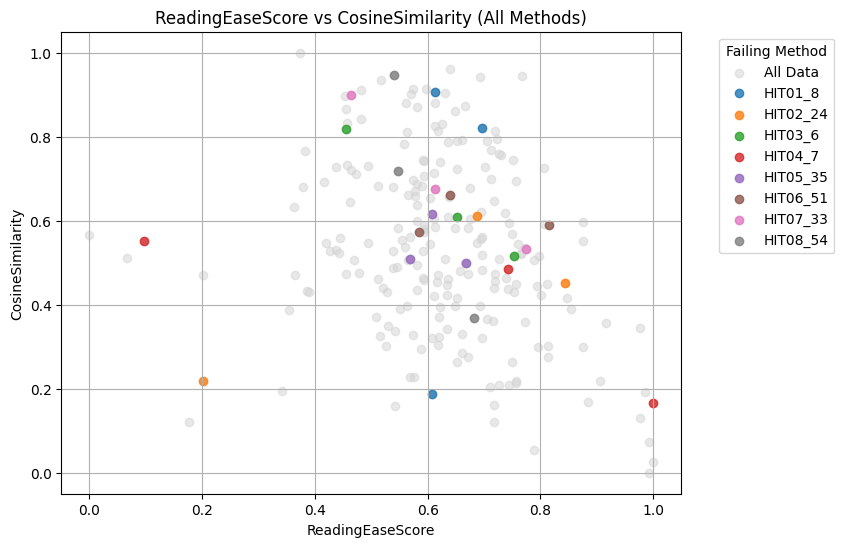

In [75]:
best_subsets_div, subset_entropies_div = find_best_subsets(3, 0.0, 0.0, 1.0)
print_subsets(best_subsets_div)
plot_best_subsets(merged_df, best_subsets_div)

#### Similarity ONLY

Processing method HIT01_8


/tmp/ipykernel_17203/431012939.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, method_group in merged_df.groupby("FailingMethod"):


Processing method HIT02_24
Processing method HIT03_6
Processing method HIT04_7
Processing method HIT05_35
Processing method HIT06_51
Processing method HIT07_33
Processing method HIT08_54
Failing Method: HIT01_8
Entropy:  0.3991502531447387
    Answer.ID  ReadingEaseScore  CosineSimilarity
4         446          0.373778          1.000000
11        457          0.597269          0.914090
13        243          0.639206          0.961856
---
Failing Method: HIT02_24
Entropy:  0.32287346759589275
    Answer.ID  ReadingEaseScore  CosineSimilarity
33         65          0.580852          0.870622
37         75          0.570778          0.900686
44         85          0.649056          0.860253
---
Failing Method: HIT03_6
Entropy:  0.5168546102840151
    Answer.ID  ReadingEaseScore  CosineSimilarity
51        513          0.651593          0.609090
58        491          0.454593          0.818079
64        403          0.464741          0.721411
---
Failing Method: HIT04_7
Entropy:  0.3859

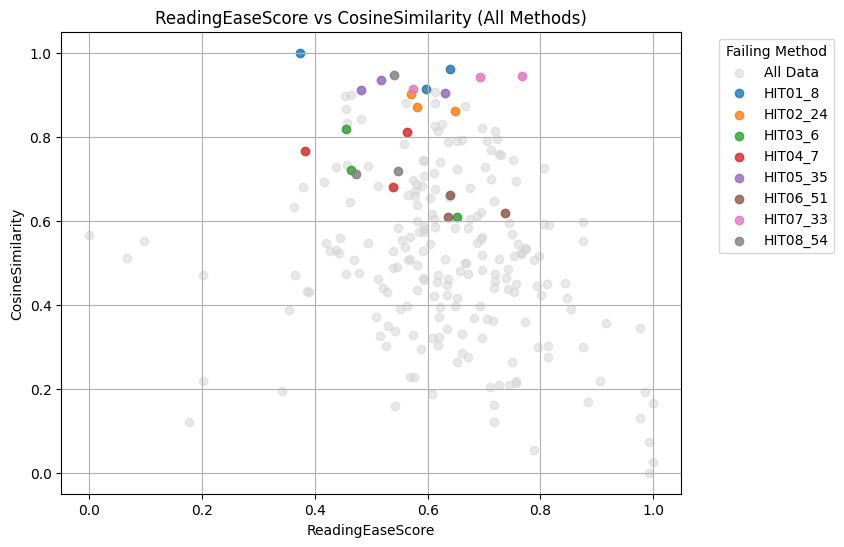

In [76]:
best_subsets_sim, subset_entropies_sim = find_best_subsets(3, 0.0, 1.0, 0.0)
print_subsets(best_subsets_sim)
plot_best_subsets(merged_df, best_subsets_sim)

### Readability ONLY

Processing method HIT01_8


/tmp/ipykernel_17203/431012939.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, method_group in merged_df.groupby("FailingMethod"):


Processing method HIT02_24
Processing method HIT03_6
Processing method HIT04_7
Processing method HIT05_35
Processing method HIT06_51
Processing method HIT07_33
Processing method HIT08_54
Failing Method: HIT01_8
Entropy:  0.4754274225405603
    Answer.ID  ReadingEaseScore  CosineSimilarity
10        456          0.717484          0.646925
26        259          0.805612          0.591946
30        400          0.712186          0.767631
---
Failing Method: HIT02_24
Entropy:  0.2748694659181563
    Answer.ID  ReadingEaseScore  CosineSimilarity
35         68          0.750019          0.569268
43         84          0.843445          0.450973
45         88          0.813148          0.274429
---
Failing Method: HIT03_6
Entropy:  0.4928521490337524
    Answer.ID  ReadingEaseScore  CosineSimilarity
60        493          1.000000          0.025215
69        418          0.977315          0.131077
73        589          0.992463          0.073573
---
Failing Method: HIT04_7
Entropy:  0.40572

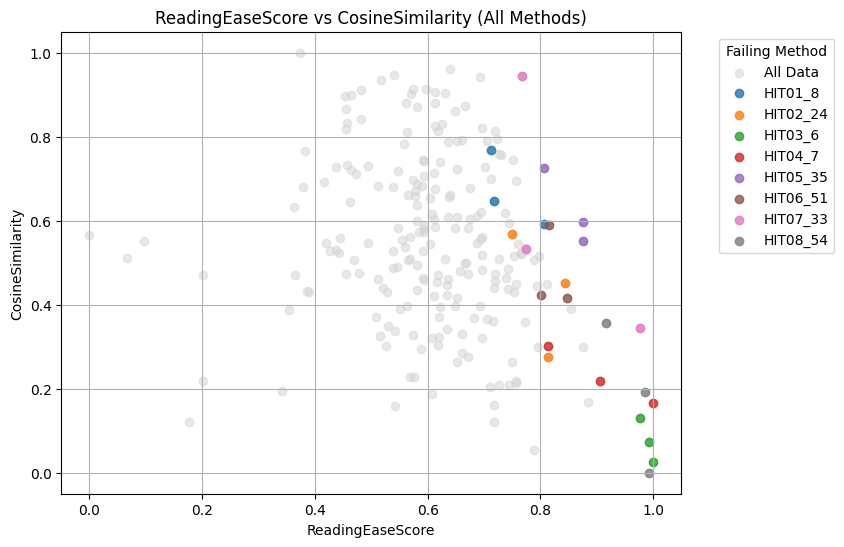

In [77]:
best_subsets_read, subset_entropies_read = find_best_subsets(3, 1.0, 0.0, 0.0)
print_subsets(best_subsets_read)
plot_best_subsets(merged_df, best_subsets_read)

### Entropies of different configurations

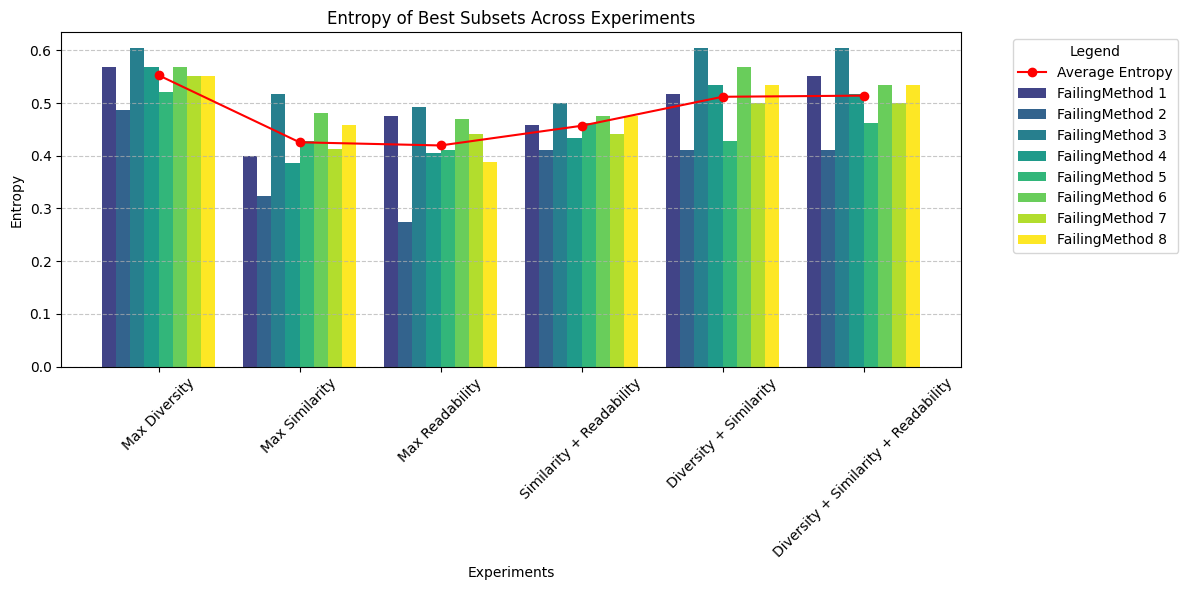

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_entropies is already computed

methods = list(best_entropies.keys())  # Failing methods
num_experiments = max(len(v) for v in best_entropies.values())  # Max number of experiments

# Define colors for experiments
colors = plt.cm.viridis(np.linspace(0.2, 1, num_experiments))

# Create bar chart
x = np.arange(len(methods))  # X positions for methods
width = 0.1  # Bar width

plt.figure(figsize=(12, 6))

# Compute average entropy per experiment
average_entropies = {key: np.mean(values) for key, values in best_entropies.items()}

for i in range(num_experiments):
    entropies = [best_entropies[method][i] if i < len(best_entropies[method]) else np.nan for method in methods]
    plt.bar(x + i * width, entropies, width, color=colors[i], label=f'FailingMethod {i+1}')

# Overlay average entropy as a line plot
avg_entropy_values = [average_entropies[method] for method in methods]  # Extract average entropies in order
plt.plot(x + (num_experiments - 1) * width / 2, avg_entropy_values, marker='o', linestyle='-', color='red', label='Average Entropy')

# Labels and title
plt.xlabel("Experiments")
plt.ylabel("Entropy")
plt.title("Entropy of Best Subsets Across Experiments")
plt.xticks(x + (num_experiments - 1) * width / 2, methods, rotation=45)  # Center xticks
plt.legend(title="Experiment")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Move legend outside the plot
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to fit legend
plt.tight_layout()

# Show plot
plt.show()


In [90]:
best_entropies

{'Max Diversity': [np.float64(0.5691291238418227),
  np.float64(0.48627843481491245),
  np.float64(0.6039796038356268),
  np.float64(0.5691296751345073),
  np.float64(0.5211258091531417),
  np.float64(0.5691294511159072),
  np.float64(0.551704058716472),
  np.float64(0.551704392728574)],
 'Max Similarity': [np.float64(0.3991502531447387),
  np.float64(0.32287346759589275),
  np.float64(0.5168546102840151),
  np.float64(0.3859966534087132),
  np.float64(0.4274235418461908),
  np.float64(0.48200417576696153),
  np.float64(0.41230478277247207),
  np.float64(0.45800253045784944)],
 'Max Readability': [np.float64(0.4754274225405603),
  np.float64(0.2748694659181563),
  np.float64(0.4928521490337524),
  np.float64(0.405727728273239),
  np.float64(0.40999893209944865),
  np.float64(0.4688505823509394),
  np.float64(0.44057746394720004),
  np.float64(0.3883022540433365)],
 'Similarity + Readability': [np.float64(0.45800215200353805),
  np.float64(0.4099983411906188),
  np.float64(0.49942977107

In [85]:
for k, v in best_subsets_experiments.items():
  for a, b in v.items():
    print(b)

    Answer.ID FailingMethod  Question.ID  Answer.duration  Answer.confidence  \
0         441       HIT01_8            1          140.407                  4   
14        244       HIT01_8            4           42.667                  3   
19        252       HIT01_8            4          271.580                  5   

    Answer.difficulty Answer.option  Answer.order  \
0                   3           YES             3   
14                  5           YES             2   
19                  1           YES             1   

                                   Answer.explanation  Code.LOC  ...  \
0   Minutes are set to -15; which is less then 0 a...         1  ...   
14  There may be an issue as it involves not indig...         3  ...   
19  Line 279 written as "minutesOffset < 0" makes ...         3  ...   

         Worker.profession Worker.yearsOfExperience  Worker.age Worker.gender  \
0    Undergraduate_Student                      3.0          49        Female   
14  Professiona